In [1]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import scipy.stats as st

dt = 0.1
tstart = 0
tlim = 250
t = np.arange(tstart, tlim, 1)

d_cut = 210

ndiv = 1/dt

### keep it always starting at 0
tmoh = np.arange(0, tlim, dt)

N_city = 1

PHU_path = './../../PHU_Data/'
figpath = './../../figs/predictions/toronto_synth_210'
datapath = './../../data'

Data = np.zeros([365,4])

files = os.listdir(PHU_path)

target_file1 = f'{PHU_path}/30-Toronto.csv'
target_file2 = f'{PHU_path}/34-York.csv'
target_file3 = f'{PHU_path}/04-Durham.csv'
target_file4 = f'{PHU_path}/22-PeelRegion.csv'
# target_file5 = f'{datapath}/toronto_synthetic_data_noise10.csv'

target_file5 = f'{datapath}/coupled_synth_data_r100.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')


population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')


#### CHANgE HERE ########
file = np.genfromtxt(target_file5, delimiter=',')
x_data = file[:,0]
# x_data = Data[:,0]
t_data = np.arange(0,tlim)


# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))


# For noisy synthetic model output
I_model = np.zeros((len(t),N_city))
I_synthetic = np.zeros((len(t),N_city))

 
total = np.zeros((N_city))

 ####### CHANGE HERE ######################
total[0] = population_by_phu[29,1]
 #####################################

# # Initial Conditions
#  ####### CHANGE HERE ######################
# E[0,0] = Data[0,0]
# I[0,0] = Data[0,0]
#  #####################################
# R[0,0] = 0
# D[0,0] = 0
# N[0,0] = total[0]
# S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]


# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected in PHU1",I[0,0])

print("total population in PHU1",total[0])

#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992


initial infected in PHU1 0.0
total population in PHU1 2794356.0


In [2]:

# True data

sample_path = datapath

true_path  =  f'{datapath}/coupled_toronto_synth_truth_all.csv'

beta_true_path  = f'{datapath}/coupled_synth_true_beta.csv'

all_truth = np.genfromtxt(true_path, delimiter=',')

beta_truth = np.loadtxt(beta_true_path,delimiter=',')

S_mean = np.zeros((len(tmoh),N_city))
E_mean = np.zeros((len(tmoh),N_city))
I_mean = np.zeros((len(tmoh),N_city))
R_mean = np.zeros((len(tmoh),N_city))
D_mean = np.zeros((len(tmoh),N_city))
beta_mean = np.zeros((len(tmoh),N_city))


samples = np.loadtxt(f'{sample_path}/muVec_toronto_synth_210.dat')

# samples = np.loadtxt(f'{sample_path}/muVec_real_case2.dat')

print(samples.shape)

Nsamples = len(samples[0,:])

I_pdf = np.zeros((tlim-d_cut,Nsamples))


for ns in range(Nsamples):

        # Initial Conditions
    ####### CHANGE HERE ######################
    E[0,0] = samples[0,ns]
    I[0,0] = samples[1,ns]
    #####################################

    R[0,0] = 0
    D[0,0] = 0
    N[0,0] = total[0]
    S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]


### Toronto
    a0 = samples[2,ns]
    a1 = samples[3,ns]
    t1 =  20
    a2 = samples[4,ns]
    t2 =  35
    a3 =  samples[5,ns]
    t3 = 60
    a4 =  samples[6,ns]
    t4 = 80
    a5 =  samples[7,ns]
    t5 =  140
    a6 =  samples[8,ns]
    t6 = 180
    a7 =  samples[9,ns]
    t7 =  190


    beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh)))  + a5/(1 + np.exp((t5-tmoh))) \
          + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))

    beta_mean[:,0] = beta_mean[:,0] + beta_i[:,0]
    

    beta_e[:,0] = beta_i[:,0]

    idxmoh = 0

    #### With mobility tensor   

    FoI = np.zeros((len(tmoh),1))
        
    for kk in range(1,len(tmoh)):

        FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

        S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
        E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
        
        I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
        R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
        D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
        N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]

 # Compute mean predictions
        S_mean[kk,0] = S_mean[kk,0] + S[kk,0]
        E_mean[kk,0] = E_mean[kk,0] + E[kk,0]
        I_mean[kk,0] = I_mean[kk,0] + I[kk,0]
        R_mean[kk,0] = R_mean[kk,0] + R[kk,0]
        D_mean[kk,0] = D_mean[kk,0] + D[kk,0]
        

        if( kk%ndiv == 0):
            idxmoh = int(kk/ndiv)

            if(idxmoh >= d_cut):

                I_pdf[idxmoh-d_cut,ns] = I[kk,0]



S_mean = S_mean/Nsamples
E_mean = E_mean/Nsamples
I_mean = I_mean/Nsamples
R_mean = R_mean/Nsamples
D_mean = D_mean/Nsamples

beta_mean = beta_mean/Nsamples


(10, 4000)


In [3]:
E_mean[0,0] = sum(samples[0,:],1)/Nsamples
I_mean[0,0] = sum(samples[1,:],1)/Nsamples


S_mean[0,0] = S[0,0]
R_mean[0,0] = R[0,0]
D_mean[0,0] = D[0,0]

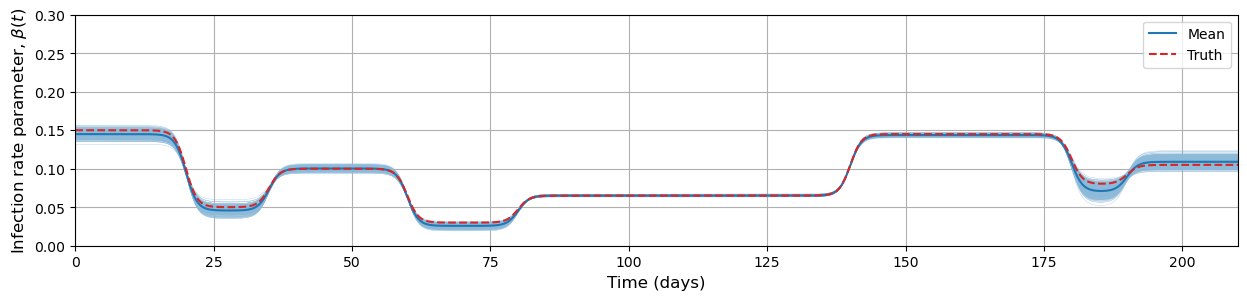

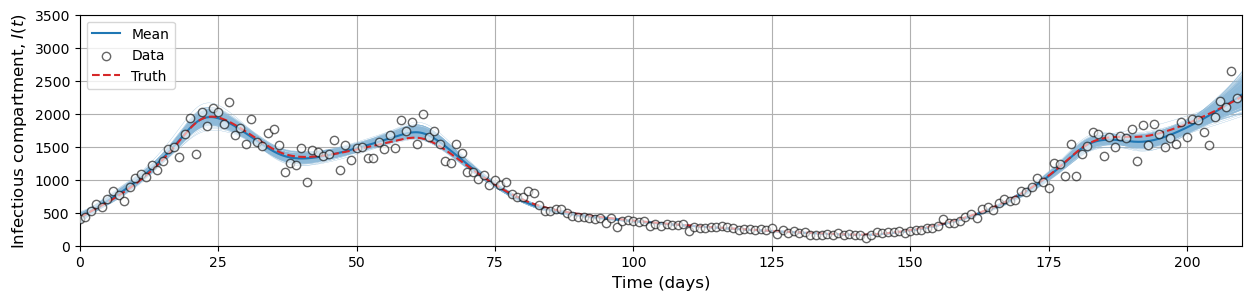

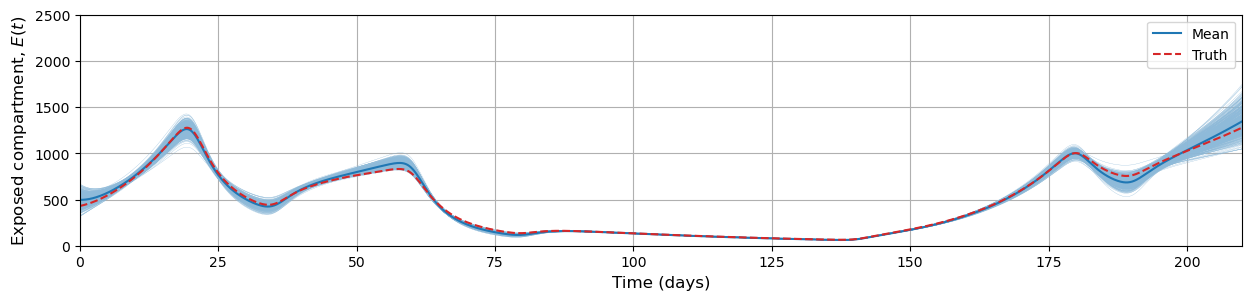

In [4]:
##### Printing beta samples

pred_low = int(tstart*ndiv)

pred_high = int(tlim*ndiv)

Nsamples = 500


for ns in range(Nsamples):

    ### Toronto
    # Initial Conditions
    ####### CHANGE HERE ######################
    E[0,0] = samples[0,ns]
    I[0,0] = samples[1,ns]
    #####################################

    R[0,0] = 0
    D[0,0] = 0
    N[0,0] = total[0]
    S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]

    a0 = samples[2,ns]
    a1 = samples[3,ns]
    t1 =  20
    a2 = samples[4,ns]
    t2 =  35
    a3 =  samples[5,ns]
    t3 = 60
    a4 =  samples[6,ns]
    t4 = 80
    a5 =  samples[7,ns]
    t5 =  140
    a6 =  samples[8,ns]
    t6 = 180
    a7 =  samples[9,ns]
    t7 =  190


    beta_i[:,0] = a0 + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh))) \
        + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))
    beta_e[:,0] = beta_i[:,0]

    if ns == 0:
        beta_append=beta_e
    else:
        beta_append=np.hstack((beta_append,beta_e))

    # ax1.plot(tmoh[pred_low:pred_high], beta_i[pred_low:pred_high,0], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')


    idxmoh = 0

    #### With mobility tensor   

    FoI = np.zeros((len(tmoh),1))
        
    for kk in range(1,len(tmoh)):

        FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

        S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
        E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
        
        I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
        R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
        D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
        N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]

    if ns == 0:
        s_append=S[:,0]
        e_append=E[:,0]
        i_append=I[:,0]
        r_append=R[:,0]
        d_append=D[:,0]
    else:
        s_append=np.vstack((s_append,S[:,0]))
        e_append=np.vstack((e_append,E[:,0]))
        i_append=np.vstack((i_append,I[:,0]))
        r_append=np.vstack((r_append,R[:,0]))
        d_append=np.vstack((d_append,D[:,0]))

s_append=s_append.T
e_append=e_append.T
i_append=i_append.T
r_append=r_append.T
d_append=d_append.T


mpl.rcParams.update({'font.size':10})
fig1, ax1 = plt.subplots(figsize=(15, 3))
# ax1.set_xlim([0,40])
# ax1.set_yticks(np.arange(0, 5000, 50.0))
ax1.set_xlabel('Time (days)', fontsize=12)
ax1.set_ylabel(r'Infection rate parameter, $\beta(t)$', fontsize=12)
ax1.plot(tmoh[pred_low:pred_high], beta_append[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax1.plot(tmoh[pred_low:pred_high], beta_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
ax1.plot(tmoh[pred_low:pred_high], beta_truth[pred_low:pred_high,0], color='tab:red',linestyle='--', label='Truth')
# ax1.axvline(x=d_cut, color='g', linestyle='--')
# ax1.set_xticks(np.arange(0,50, 10), labels=['0', '10', '20', '30', '40'])
ax1.legend()
ax1.grid()
plt.xlim([0,d_cut])
plt.ylim([0,0.3])
ax1.figure.savefig(f'{figpath}/beta_synth_uncertainty.pdf', bbox_inches='tight')
# ax1.figure.savefig(f'{figpath}/beta_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()

fig2, ax2 = plt.subplots(figsize=(15, 3))
# ax1.set_xlim([0,40])
# ax1.set_yticks(np.arange(0, 5000, 50.0))
ax2.set_xlabel('Time (days)', fontsize=12)
ax2.set_ylabel(r'Infectious compartment, $I(t)$', fontsize=12)
ax2.plot(tmoh[pred_low:pred_high], i_append[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax2.plot(tmoh[pred_low:pred_high], I_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
plt.scatter(t_data[0:d_cut],x_data[0:d_cut],color='w',edgecolors='k',zorder=3,alpha=0.6,label='Data')
ax2.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,2], color='tab:red',linestyle='--', label='Truth')
# ax1.axvline(x=d_cut, color='g', linestyle='--')
# ax1.set_xticks(np.arange(0,50, 10), labels=['0', '10', '20', '30', '40'])
ax2.legend()
ax2.grid()
plt.xlim([0,d_cut])
plt.ylim([0,3500])
ax2.figure.savefig(f'{figpath}/i_synth_uncertainty.pdf', bbox_inches='tight')
# ax2.figure.savefig(f'{figpath}/i_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()



fig4, ax4 = plt.subplots(figsize=(15, 3))
ax4.set_xlabel('Time (days)', fontsize=12)
ax4.set_ylabel(r'Exposed compartment, $E(t)$', fontsize=12)
ax4.plot(tmoh[pred_low:pred_high], e_append[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax4.plot(tmoh[pred_low:pred_high], E_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
ax4.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,1], color='tab:red',linestyle='--', label='Truth')
# plt.scatter(t_data,x_data[0:160],color='w',edgecolors='k',zorder=1,alpha=0.6,label='Data')
ax4.legend()
ax4.grid()
plt.xlim([0,d_cut])
plt.ylim([0,2500])
# ax4.figure.savefig(f'{figpath}/e_synthetic_uncertainty.pdf', bbox_inches='tight')
ax4.figure.savefig(f'{figpath}/e_synth_uncertainty.pdf', bbox_inches='tight')
plt.show()



(400, 500)
(400, 500)


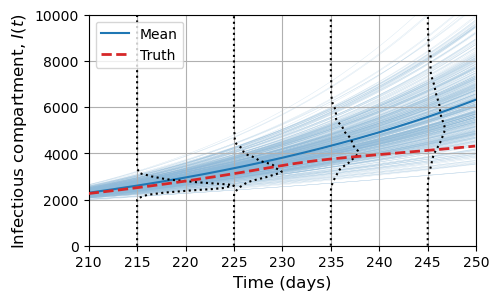

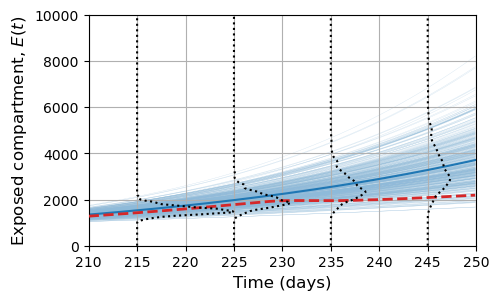

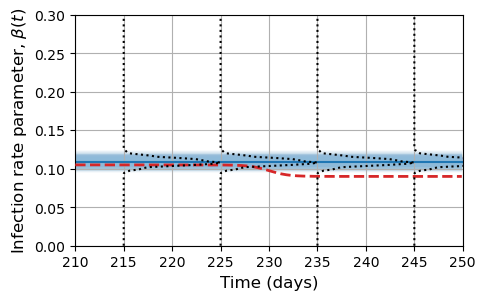

In [5]:
# d_cut = 160

pred_low = int(d_cut*ndiv)

pred_high = int(tlim*ndiv)

Nsamples = 500

for ns in range(Nsamples):


    ### Toronto
    # Initial Conditions
    ####### CHANGE HERE ######################
    E[0,0] = samples[0,ns]
    I[0,0] = samples[1,ns]
    #####################################

    R[0,0] = 0
    D[0,0] = 0
    N[0,0] = total[0]
    S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]

    a0 = samples[2,ns]
    a1 = samples[3,ns]
    t1 =  20
    a2 = samples[4,ns]
    t2 =  35
    a3 =  samples[5,ns]
    t3 = 60
    a4 =  samples[6,ns]
    t4 = 80
    a5 =  samples[7,ns]
    t5 =  140
    a6 =  samples[8,ns]
    t6 = 180
    a7 =  samples[9,ns]
    t7 =  190

    beta_i[:,0] = a0 + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh))) \
          + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))
    beta_e[:,0] = beta_i[:,0]

    if ns == 0:
        beta_append=beta_e
    else:
        beta_append=np.hstack((beta_append,beta_e))

    # ax1.plot(tmoh[pred_low:pred_high], beta_i[pred_low:pred_high,0], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')


    idxmoh = 0

    #### With mobility tensor   

    FoI = np.zeros((len(tmoh),1))
        
    for kk in range(1,len(tmoh)):

        FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

        S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
        E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
        
        I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
        R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
        D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
        N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]


    if ns == 0:
        s_append=S[:,0]
        e_append=E[:,0]
        i_append=I[:,0]
        r_append=R[:,0]
        d_append=D[:,0]
    else:
        s_append=np.vstack((s_append,S[:,0]))
        e_append=np.vstack((e_append,E[:,0]))
        i_append=np.vstack((i_append,I[:,0]))
        r_append=np.vstack((r_append,R[:,0]))
        d_append=np.vstack((d_append,D[:,0]))


s_append=s_append.T
e_append=e_append.T
i_append=i_append.T
r_append=r_append.T
d_append=d_append.T

print(np.shape(i_append[pred_low:pred_high,:]))
print(np.shape(beta_append[pred_low:pred_high,:]))

Igrd = np.linspace(0,10000,201)
Ipdf_0 = st.gaussian_kde(i_append[2150,:],bw_method = 0.2)
Ipdf_5 = st.gaussian_kde(i_append[2250,:],bw_method = 0.2)
Ipdf_10 = st.gaussian_kde(i_append[2350,:],bw_method = 0.2)
Ipdf_15 = st.gaussian_kde(i_append[2450,:],bw_method = 0.2)
# Ipdf_20 = st.gaussian_kde(i_append[2000,:],bw_method = 0.2)
Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd)])
# Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd),Ipdf_20(Igrd)])


Egrd = np.linspace(0,10000,201)
Epdf_0 = st.gaussian_kde(e_append[2150,:],bw_method = 0.2)
Epdf_5 = st.gaussian_kde(e_append[2250,:],bw_method = 0.2)
Epdf_10 = st.gaussian_kde(e_append[2350,:],bw_method = 0.2)
Epdf_15 = st.gaussian_kde(e_append[2450,:],bw_method = 0.2)
# Ipdf_20 = st.gaussian_kde(i_append[2000,:],bw_method = 0.2)
Emax = np.max([Epdf_0(Egrd),Epdf_5(Egrd),Epdf_10(Egrd),Epdf_15(Egrd)])
# Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd),Ipdf_20(Igrd)])



Bgrd = np.linspace(0,0.3,201)
Bpdf_0 = st.gaussian_kde(beta_append[2150,:],bw_method = 0.2)
Bpdf_5 = st.gaussian_kde(beta_append[2250,:],bw_method = 0.2)
Bpdf_10 = st.gaussian_kde(beta_append[2350,:],bw_method = 0.2)
Bpdf_15 = st.gaussian_kde(beta_append[2450,:],bw_method = 0.2)
Bmax = np.max([Bpdf_0(Igrd),Bpdf_5(Bgrd),Bpdf_10(Bgrd),Bpdf_15(Bgrd)])

t_data = np.arange(0,tlim+1)

f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], i_append[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), zorder=1, linewidth=0.2, label='_nolegend_')
# plt.scatter(t_data[d_cut:tlim+1],x_data[d_cut:tlim+1],color='w',edgecolors='k',zorder=3,alpha=0.6,label='Data')
plt.plot(tmoh[pred_low:pred_high], I_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', zorder=2, label='Mean')
plt.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,2], linewidth=2, color='tab:red',linestyle='--', zorder=4, label='Truth')
plt.grid(True)
plt.plot(215+Ipdf_0(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(225+Ipdf_5(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(235+Ipdf_10(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(245+Ipdf_15(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.xlim([d_cut,tlim])
plt.ylim([0,1e4])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Infectious compartment, $I(t)$', fontsize=12)
ax.legend(loc='upper left')
plt.savefig(f'{figpath}/forecast_i_synth_toronto_sigmoid.pdf',bbox_inches='tight')



f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], e_append[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), zorder=1,linewidth=0.2, label='_nolegend_')
plt.plot(tmoh[pred_low:pred_high], E_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', zorder=2, label='Mean')
plt.plot(tmoh[pred_low:pred_high], all_truth[pred_low:pred_high,1], color='tab:red',linewidth=2, linestyle='--', zorder=3, label='Truth')
plt.grid(True)
plt.plot(215+Epdf_0(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(225+Epdf_5(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(235+Epdf_10(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(245+Epdf_15(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.xlim([d_cut,tlim])
plt.ylim([0,1e4])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Exposed compartment, $E(t)$', fontsize=12)
plt.savefig(f'{figpath}/forecast_e_synth_toronto.pdf',bbox_inches='tight')


f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], beta_append[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5),zorder=1, linewidth=0.2, label='_nolegend_')
plt.plot(tmoh[pred_low:pred_high], beta_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', zorder=2,label='Mean')
plt.plot(tmoh[pred_low:pred_high], beta_truth[pred_low:pred_high,0],linewidth=2,c='tab:red',linestyle='--', zorder=3, label='Truth')
plt.grid(True)
plt.plot(215+Bpdf_0(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(225+Bpdf_5(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(235+Bpdf_10(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(245+Bpdf_15(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.xlim([d_cut,tlim])
plt.ylim([0,0.3])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Infection rate parameter, $\beta(t)$', fontsize=12)
plt.savefig(f'{figpath}/forecast_beta_synth_toronto.pdf',bbox_inches='tight')


/var/folders/lr/4h04vl_92s3d0hrwg37l8g740000gn/T/ipykernel_27324/3016821349.py:24: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(kde_fun,true, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})


496.81698249685394 67.33094784546296 466.94139610160573
408.0960425281117 36.339917954121724 403.8490367876901
0.14494123917414595 0.0038635526289371065 0.14654442815888202


/var/folders/lr/4h04vl_92s3d0hrwg37l8g740000gn/T/ipykernel_27324/3016821349.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(1, figsize=(3,3))


-0.09927629074813805 0.006916253267965675 -0.09797453711714368
0.05463412868696544 0.005191937211167221 0.04974299405171307
-0.07451358744891272 0.003660009962785425 -0.07052708351242264
0.0392858542755002 0.0024612747805536255 0.03631645313081831
0.07865203588799305 0.0015924088207531328 0.0800497026433486
-0.0733586340618816 0.006348109233232323 -0.06660067835872588
0.03866244575204932 0.00962186338213509 0.02473596400911067


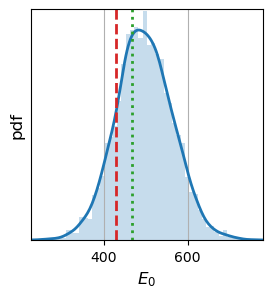

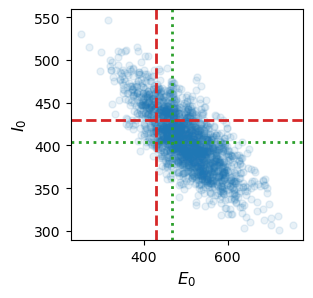

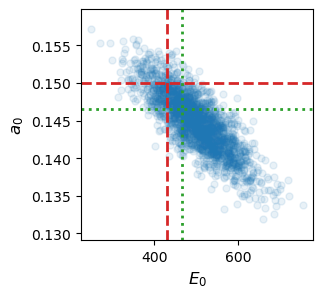

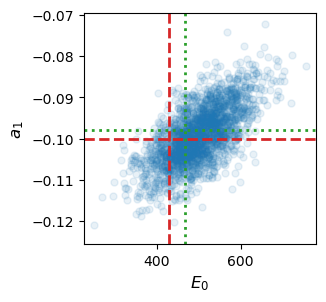

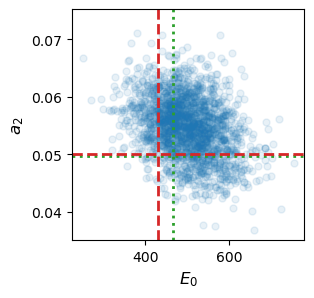

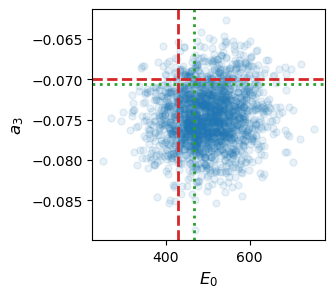

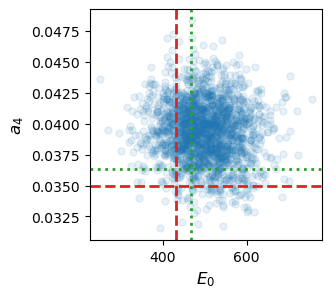

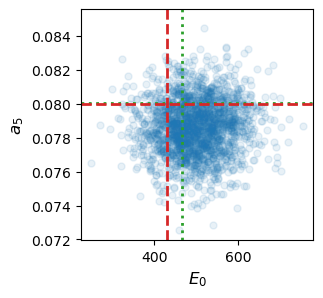

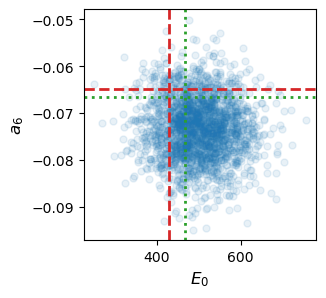

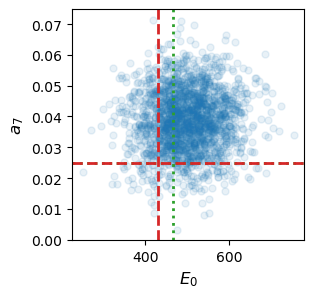

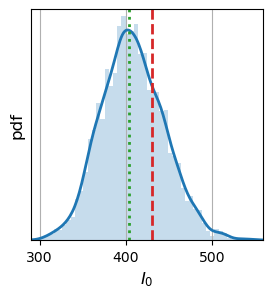

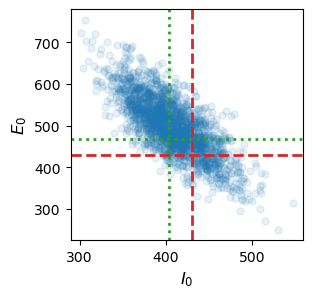

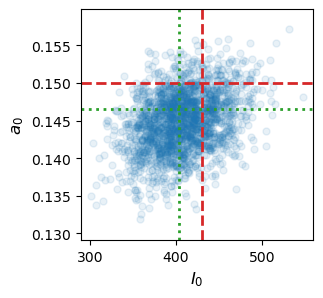

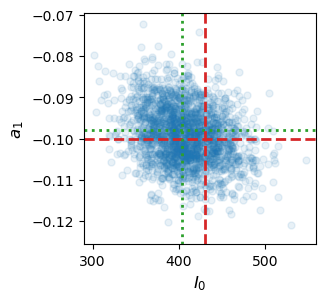

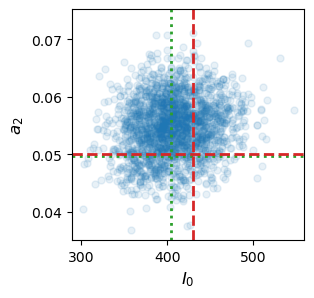

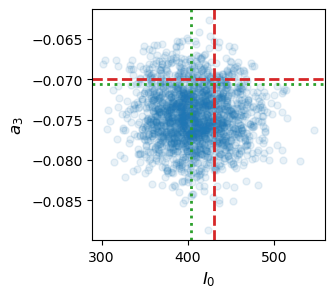

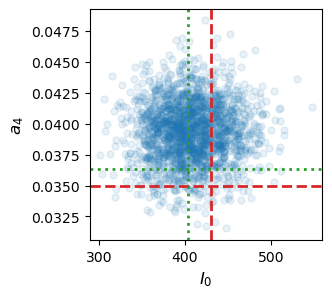

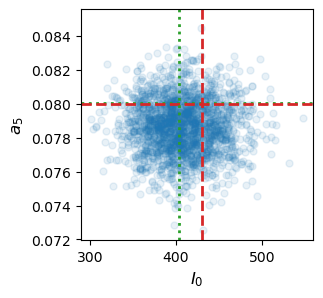

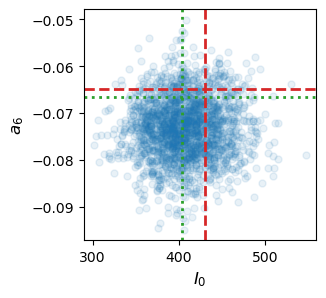

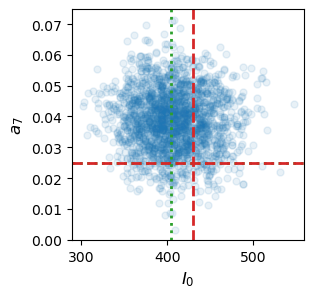

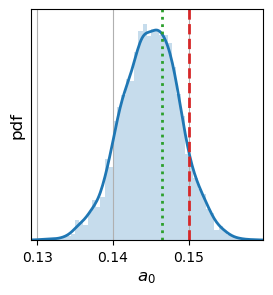

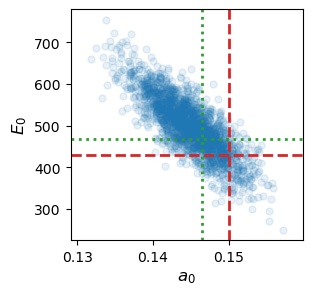

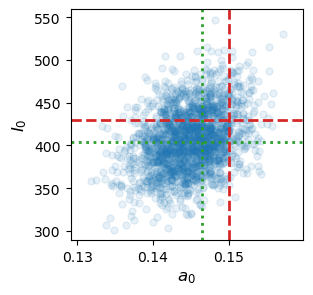

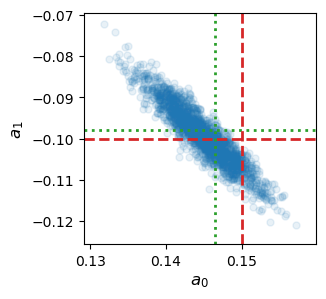

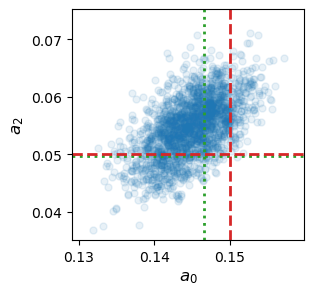

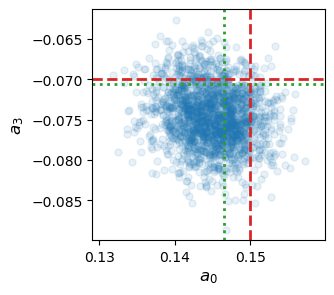

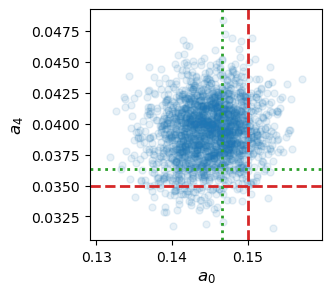

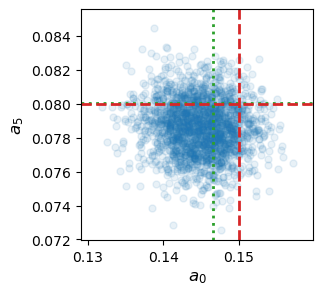

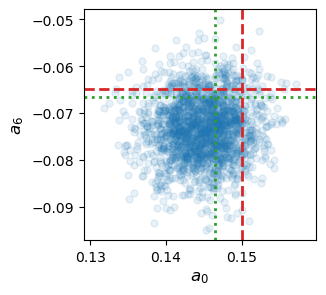

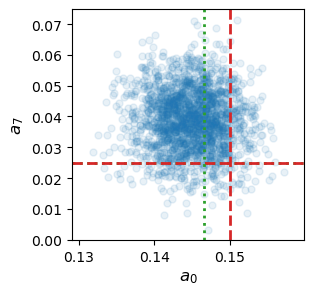

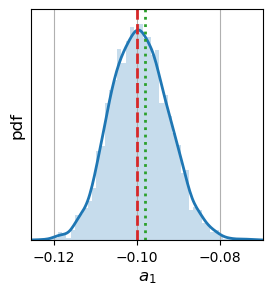

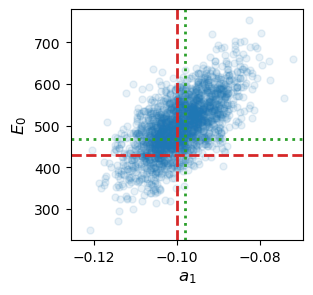

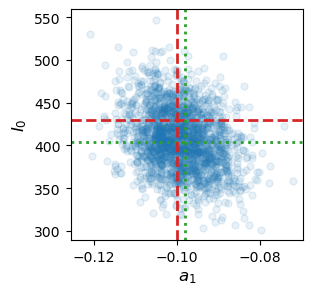

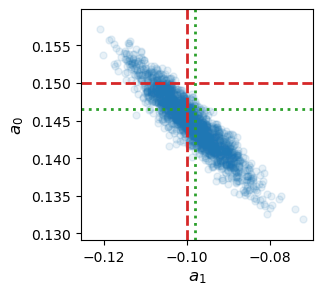

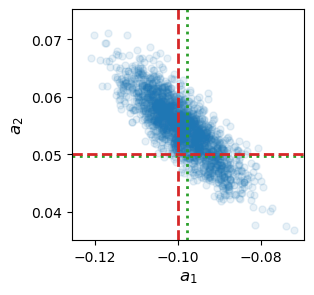

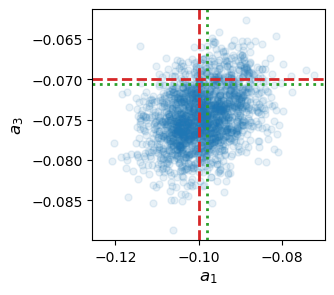

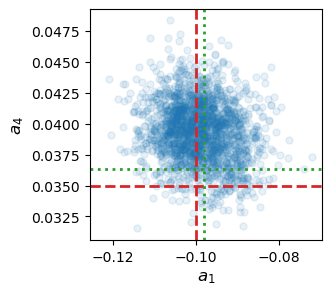

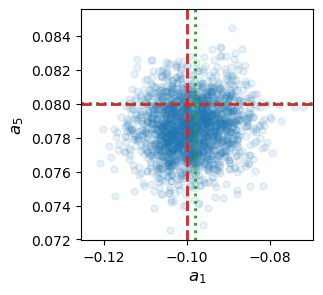

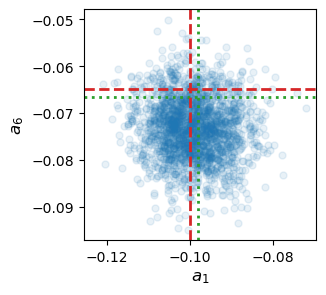

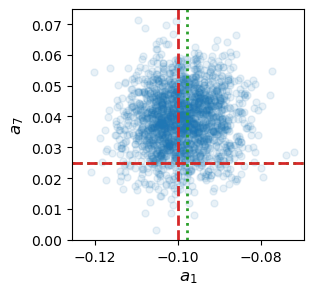

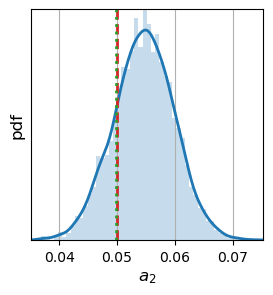

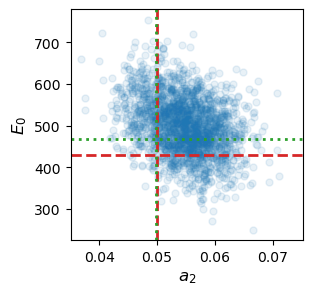

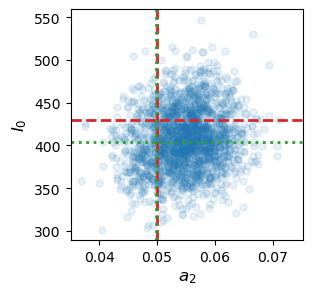

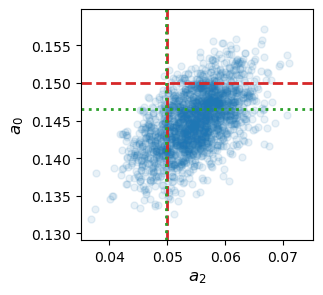

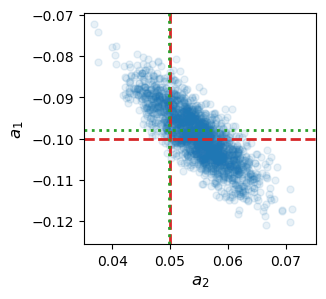

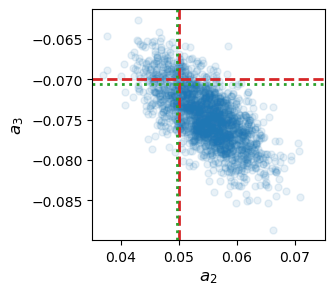

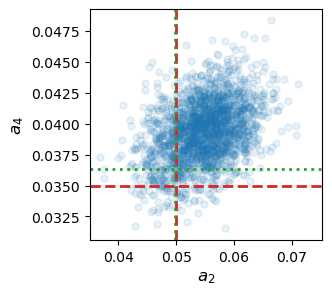

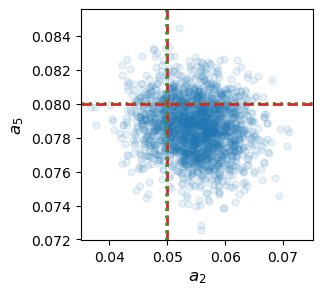

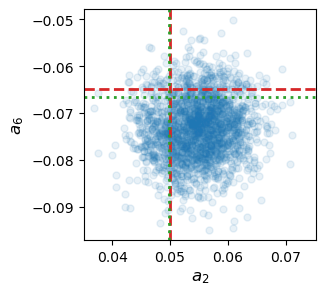

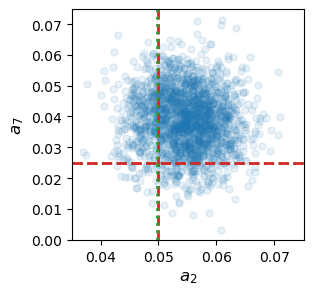

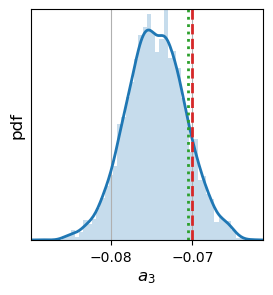

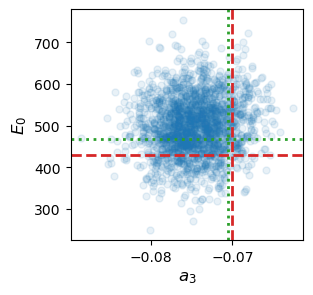

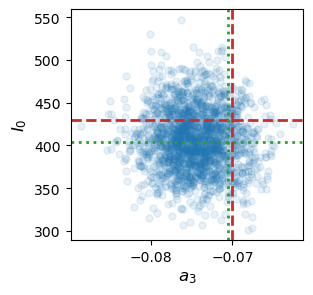

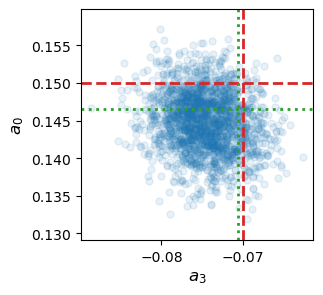

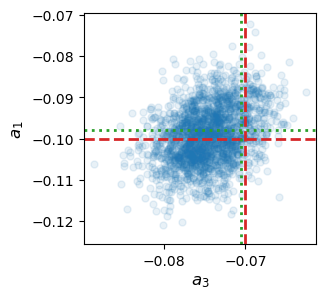

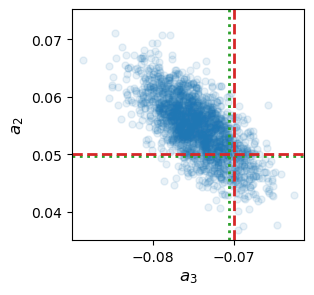

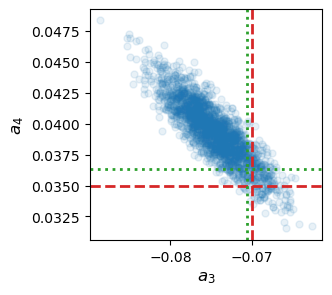

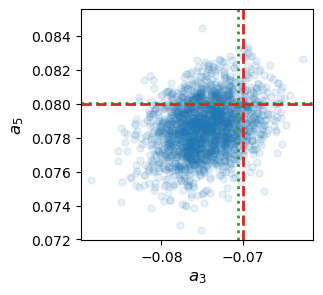

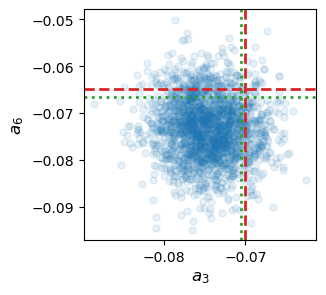

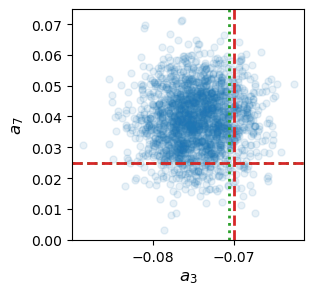

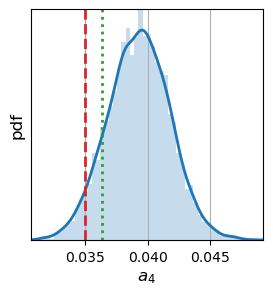

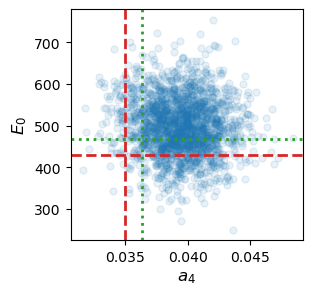

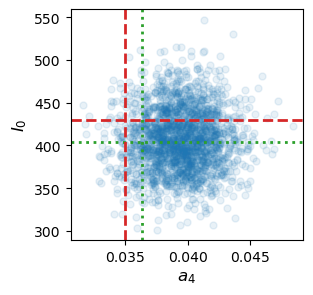

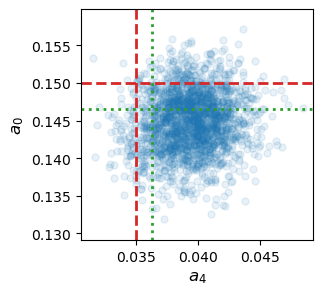

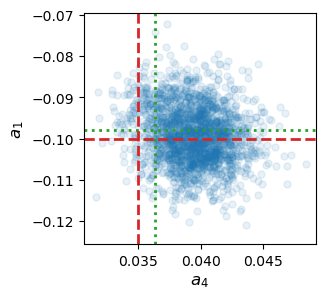

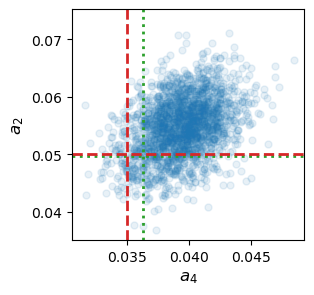

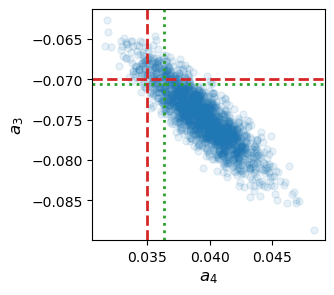

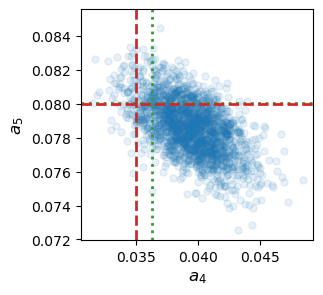

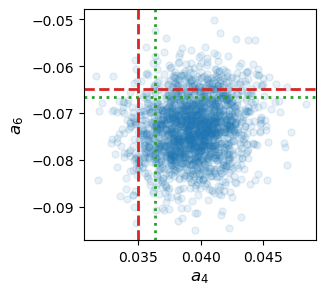

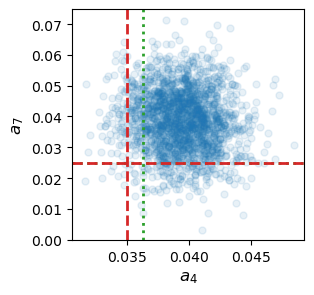

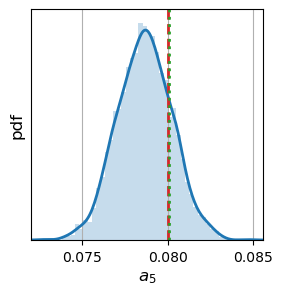

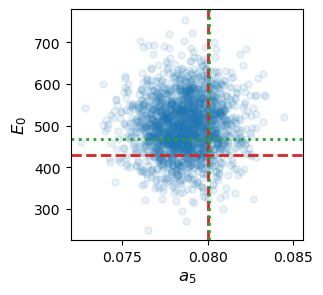

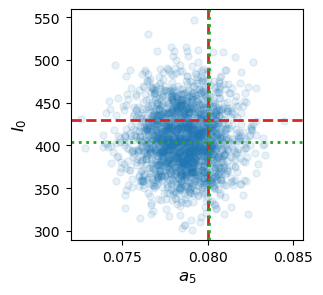

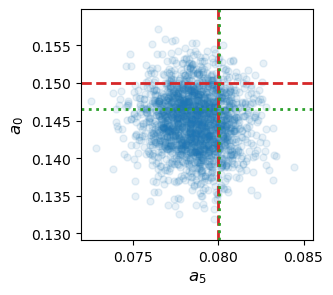

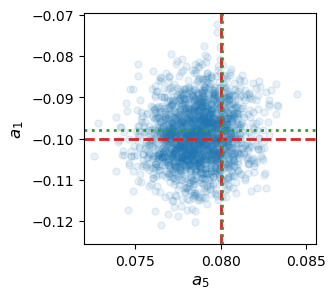

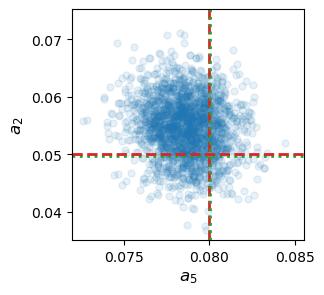

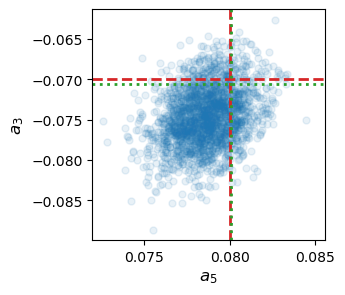

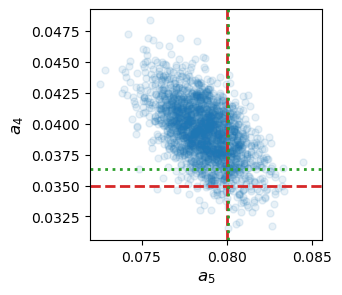

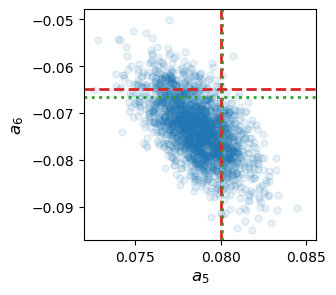

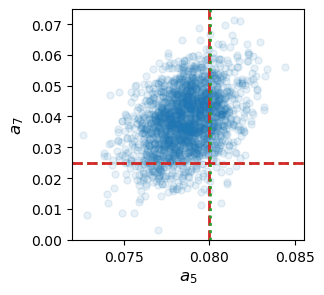

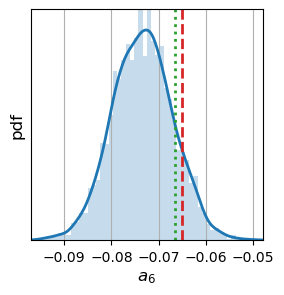

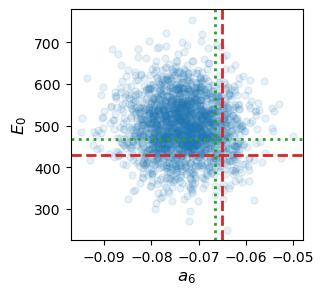

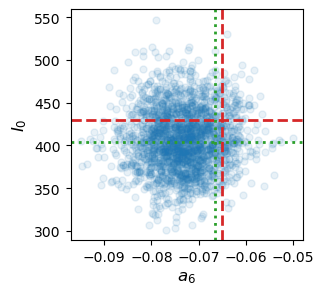

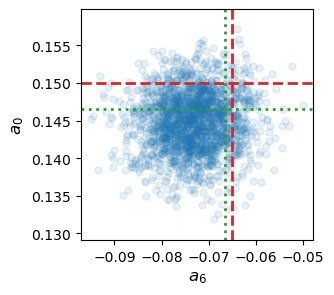

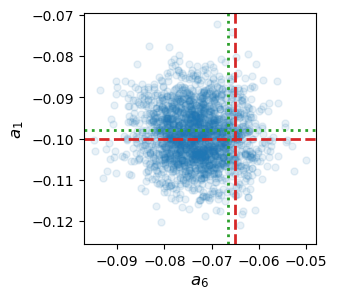

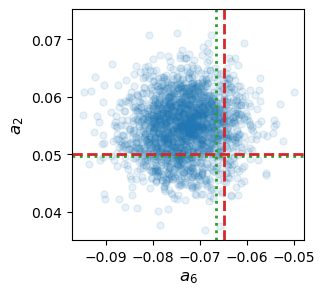

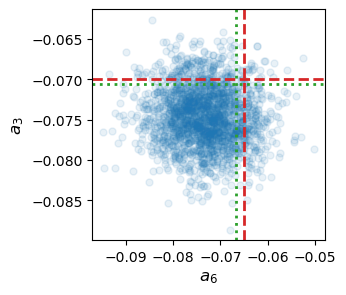

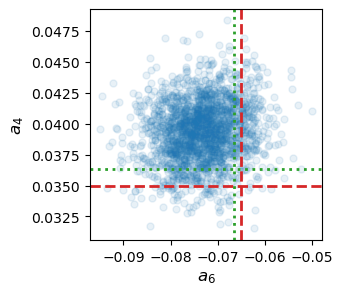

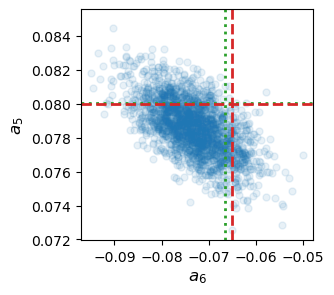

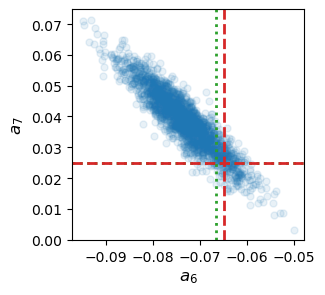

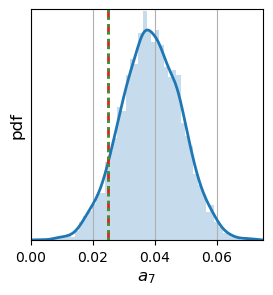

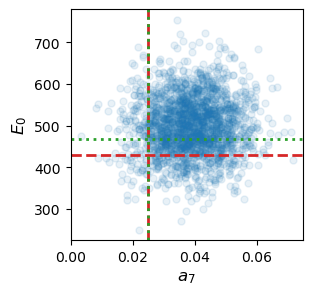

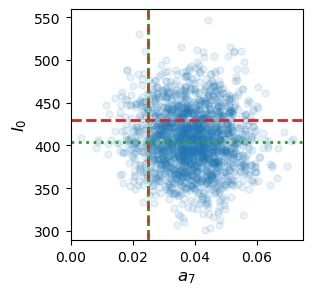

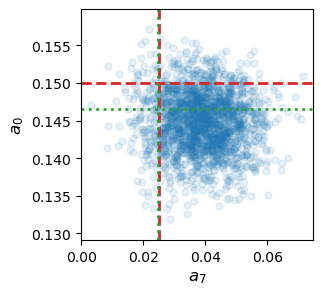

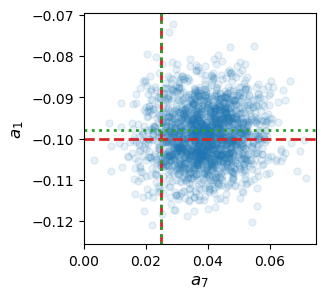

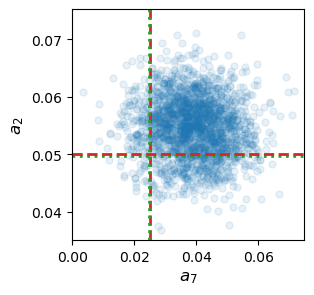

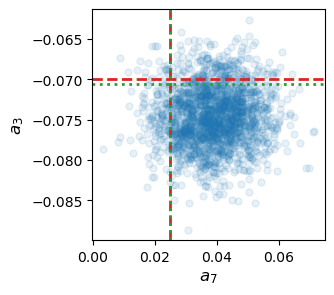

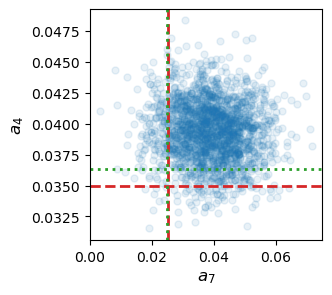

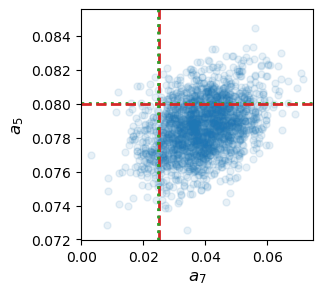

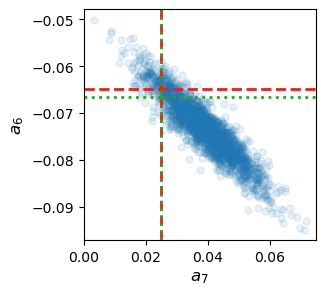

In [6]:
## Model Full
skip = 2

# samples = np.loadtxt('../../data/muVec_synth_noise10_initial.dat')
# samples = np.loadtxt('../../data/muVec_real.dat')
label = [r'$E_0$', r'$I_0$', r'$a_0$',r'$a_1$',r'$a_2$',r'$a_3$',r'$a_4$',r'$a_5$', r'$a_6$',r'$a_7$']
Npar = len(samples[:,0])


true = [ 430,430, 0.15, -0.1, 0.05,  -0.07, 0.035, 0.08, -0.065, 0.025]

# true = [430, 430, 0.15,-0.1,0.05,-0.07,0.035,0.08]

### For real data
# true = [500, 380, 0.146,-0.09,0.05,-0.06,0.020,0.085,-0.05, -0.01]


find_map = 1
if find_map == 1:
  from scipy.optimize import minimize
  kde = st.gaussian_kde(samples)
  def kde_fun(x):
    return -kde(x)
  res = minimize(kde_fun,true, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})
  # print(res.x)
  maps = res.x
  # np.savetxt('chains/ModelSIRS_SIS-map.dat',maps)

for ii in range(len(samples[:,0])):
  xmin,xmax = np.min(samples[ii,:]), np.max(samples[ii,:])
  # if param_true[ii] < xmin:
  #   xmin = param_true[ii]
  # elif  param_true[ii] > xmax:
  #   xmax = param_true[ii]

  print(np.mean(samples[ii,:]),np.std(samples[ii,:]),maps[ii])

  xmean = (xmin + xmax)/2
  xrang = (xmax - xmin)
  x_low = np.max([xmean-0.55*xrang])
  x_up = np.min([xmean+0.55*xrang])

  f, ax = plt.subplots(1, figsize=(3,3))
  Xpdf = st.gaussian_kde(samples[ii,:],bw_method = 0.2)
  # print(Xpdf.silverman_factor())
  # Xgrd = np.linspace(np.min(samples[ii,:]),np.max(samples[ii,:]))
  Xgrd = np.linspace(x_low,x_up,201)
  pdfmax = max(Xpdf(Xgrd))
  plt.plot(Xgrd,Xpdf(Xgrd),color='tab:blue',linewidth=2)
  plt.hist(samples[ii,:],bins=50,density=True,alpha=0.25)

  ### Uncomment for Synthetic data
  plt.plot([true[ii],true[ii]],[0,1.1*pdfmax],c='tab:red',linewidth=2,linestyle='--')
  plt.plot([maps[ii],maps[ii]],[0,1.1*pdfmax],c='tab:green',linewidth=2,linestyle=':')
  myYlim = [0.0, 1.1*pdfmax]
  plt.ylabel('pdf', fontsize=12)
  plt.xlabel(label[ii], fontsize=12)
  plt.ylim(myYlim)
  plt.xlim([x_low,x_up])
  plt.yticks([])
  plt.grid(True)
  plt.savefig(f'{figpath}/synth_toronto_210_mpdf_'+ str(ii)+'.pdf',bbox_inches='tight')
  # plt.close()

  for jj in range(Npar):
   if ii != jj:
      ymin,ymax = np.min(samples[jj,:]), np.max(samples[jj,:])
      ymean = (ymin + ymax)/2
      yrang = (ymax - ymin)
      y_low = np.max([ymean-0.55*yrang])
      y_up = np.min([ymean+0.55*yrang])

      f, ax = plt.subplots(1, figsize=(3,3))
      plt.scatter(samples[ii,::skip],samples[jj,::skip],alpha=0.1,s=25)
      plt.plot([x_low,x_up],[maps[jj],maps[jj]],c='tab:green',linewidth=2,linestyle=':')
      plt.plot([x_low,x_up],[true[jj],true[jj]],c='tab:red',linewidth=2,linestyle='--')
      plt.plot([true[ii],true[ii]],[y_low,y_up],c='tab:red',linewidth=2,linestyle='--')
      plt.plot([maps[ii],maps[ii]],[y_low,y_up],c='tab:green',linewidth=2,linestyle=':')
      plt.xlim([x_low,x_up])
      plt.ylim([y_low,y_up])
      plt.xlabel(label[ii],fontsize=12)
      plt.ylabel(label[jj],fontsize=12)
      plt.savefig(f'{figpath}/synth_toronto_210_jpdf_'+ str(ii)+str(jj)+'.pdf',bbox_inches='tight')
      # plt.close()